# milner video proj

In [1]:
# Import all the things.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Config
XLABEL = 'Time (s)'
YLABEL = 'Speed (m/s)'
SAVE_FIGS = False

In [3]:
RESULTS = []
STDEVS = []
PERCENT_STDEVS = []

In [4]:
# Expected values
EXPECTED_VALS = {
    5: 0.2731005628,
    10: 0.54568126315,
    15: 0.81722322821,
    20: 1.08720956241,
    25: 1.35512633141,
    30: 1.62046354042,
    35: 1.88271610498,
    40: 2.14138481242,
    45: 2.39597727217
}

## Helper funcs

In [5]:
def get_crests(df, wave_filter=None, use_troughs=False, verbose=False):
    if wave_filter is not None:
        df = wave_filter.apply_x_filter(df, verbose)
    points = df[YLABEL].tolist() # Store a list of the points from the sample.
    crests = []
    ends_of_cycles = []

    for index, point in enumerate(points): # Go through each point one by one
        try:
            if point > 0 and points[index+1] < 0:
                ends_of_cycles.append(index)
        except IndexError:
            pass


    raw_cycles = [sl.tolist() for sl in np.split(points, ends_of_cycles)][:-1]
    cycles = [x for x in raw_cycles if x != []]
    for cycle in cycles:
        crests.append(max(cycle) if use_troughs is False else min(cycle))
    if wave_filter is not None:
        crests = wave_filter.apply_y_filter(crests)
    return crests

In [6]:
def big_scary_plot(smpls):
    fig = plt.figure(figsize=[18,6])

    for frame in smpls.keys():
        fr = smpls[frame]
        plt.plot(fr[XLABEL], fr[YLABEL])

    plt.legend(smpls.keys())
    plt.grid(visible=True)
    plt.show()

In [7]:
def plot_trial_dataframe(df, name=None, xlabel=None, ylabel=None, yerr=None, graph_type=None):
    df.plot(
        x=xlabel or XLABEL,
        y=ylabel or YLABEL,
        kind=graph_type or 'line',
        figsize=(24,6),
        grid=True,
        title=name,
        xlabel=xlabel or XLABEL,
        ylabel=ylabel or YLABEL,
        yerr=yerr or None
    )

In [8]:
def filter_points(crests_list):
    abs_cr = np.absolute(crests_list)
    filtered_cr = sorted(abs_cr, reverse=True)
    return filtered_cr[0:5]

## Main computation

In [9]:
def read_in_trials(tlabel):
    deg_samples = {}
    for trial in range(1, 11):
        trial_id = f"{tlabel}-t{trial}"
        csv_name = f"{trial_id}.csv"
        try:
            df = pd.read_csv(csv_name)
            df.drop(df[df[XLABEL] == '#NUM!'].index, inplace=True)
            df.drop(df[df[YLABEL] == '#NUM!'].index, inplace=True)

            df.drop(df[df['Frequency (Hz)'] == '#NUM!'].index, inplace=True)
            df[XLABEL] = pd.to_numeric(df[XLABEL])
            df[YLABEL] = pd.to_numeric(df[YLABEL])
            df.drop(df[np.isnan(df[XLABEL])].index, inplace=True)
            df.drop(df[np.isnan(df[YLABEL])].index, inplace=True)
            # df.drop(df[np.isnan(df['Frequency (Hz)'])].index, inplace=True)
            deg_samples[trial_id] = df
        except FileNotFoundError:
            print(f'File {csv_name} not found!')
    return deg_samples

In [10]:
def run_wave_math(sample_dict, wfs_table, label, verbose=[]):
    avglist = []
    for tdf_key in sample_dict.keys():
        print(tdf_key)
        tdf = sample_dict[tdf_key]
        try:
            wf = wfs_table[tdf_key]
        except KeyError:
            wf = None
        is_verbose = len(avglist) + 1 in verbose
        crestslist = get_crests(tdf, wave_filter=wf, verbose=is_verbose)
        troughslist = get_crests(tdf, wave_filter=wf, use_troughs=True, verbose=is_verbose)
        
        if is_verbose:
            print("crests:", crestslist)
            print("troughs:", troughslist)
        tdf_crests = filter_points(crestslist)
        tdf_troughs = filter_points(troughslist)

        tdf_crests.extend(tdf_troughs)

        tdf_avg_v = np.average(tdf_crests)
        avglist.append(tdf_avg_v)
        print("trial avg v:", tdf_avg_v)
        print("~~~~~~")

    trials_avg = np.average(avglist)
    trials_stdev = np.std(avglist)
    trials_percent_stdev = (trials_stdev / trials_avg) * 100
    RESULTS.append(trials_avg)
    STDEVS.append(trials_stdev)
    PERCENT_STDEVS.append(trials_percent_stdev)

    print(f"{label} avg v:", trials_avg)
    print(f"{label} trial stdev:", trials_stdev)
    print(f"{label} trial stdev as %: {trials_percent_stdev}%")
    return avglist, trials_stdev

In [11]:
class WaveFilter():
    def __init__(self, x_min=0, x_max=4096, y_min=-4096, y_max=4096):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
    def apply_x_filter(self, df, verbose):
        df.drop(df[df[XLABEL] < self.x_min].index, inplace=True)
        df.drop(df[df[XLABEL] > self.x_max].index, inplace=True)
        
        if verbose:
            plot_trial_dataframe(df)
        return df

    def apply_y_filter(self, crestlist):
        return [y for y in crestlist if y <= self.y_max and y >= self.y_min]

In [12]:
def generate_trial_graph(deg, results, stdev):
    trial_df_data = {
        'Trial': range(1, 11),
        'Velocity': results
    }
    trial_df = pd.DataFrame(data=trial_df_data)

    trial_fig = plt.figure(figsize=[12,6])

    # plt.scatter(trial_df['Trial'], trial_df['Velocity'])
    plt.errorbar(trial_df['Trial'], trial_df['Velocity'], yerr=stdev, label='both limits (default)', capsize=4, fmt='o')
    plt.axhline(y=EXPECTED_VALS[deg], color='red')

    plt.legend(['Theoretical Velocity (m/s)', 'Velocity (m/s)'])
    plt.xlabel('Trial')
    plt.ylabel('Velocity (m/s)')
    plt.xticks(trial_df_data['Trial'])
    plt.title(f'Velocity per Trial at {deg}º')
    plt.grid(visible=True)
    # plt.graph_type = 'scatter'
    plt.show()
    trial_fig.savefig(f'assets/{deg}-results.png') if SAVE_FIGS else None

In [13]:
def run_deg_computation(deg, wf_table={}, verbose=[]):
    SAMPLES = read_in_trials(deg)
    big_scary_plot(SAMPLES)
    for item in verbose:
        plot_trial_dataframe(SAMPLES[f'{deg}-t{item}'])
    avglist, stdev = run_wave_math(SAMPLES, wf_table, f'{deg}deg', verbose=verbose)
    generate_trial_graph(deg, avglist, stdev)

## 5

In [14]:
WFS_FIVE_DEG = {
    '5-t1': WaveFilter(x_min=6, x_max=20),
    '5-t2': WaveFilter(x_min=8, x_max=18),
    '5-t3': WaveFilter(x_min=10, x_max=25),
    '5-t4': WaveFilter(x_min=9, x_max=21, y_min=-0.35),
    '5-t5': WaveFilter(x_min=10, x_max=25, y_min=-0.4, y_max=0.4),
    '5-t6': WaveFilter(x_min=12, x_max=25),
    '5-t7': WaveFilter(x_min=8, x_max=25, y_max=0.45),
    '5-t8': WaveFilter(x_min=10, x_max=20),
    '5-t9': WaveFilter(x_min=10, x_max=25),
    '5-t10': WaveFilter(x_min=11, x_max=22),
}

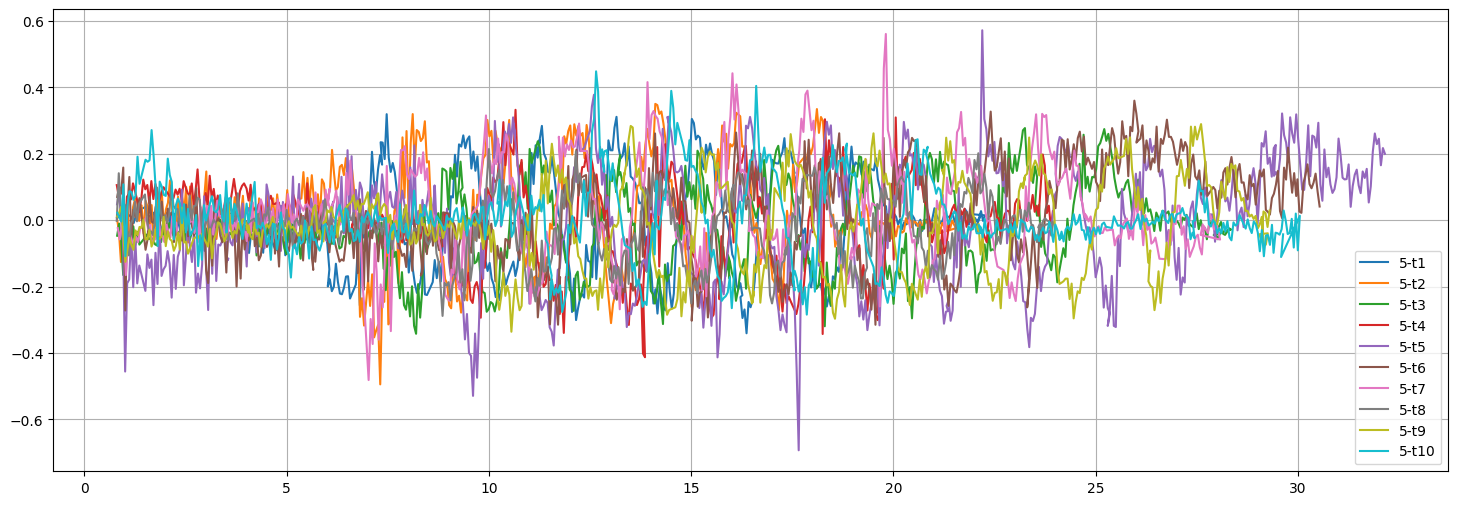

5-t1
trial avg v: 0.29144402364
~~~~~~
5-t2
trial avg v: 0.29331108674000006
~~~~~~
5-t3
trial avg v: 0.2630695973
~~~~~~
5-t4
trial avg v: 0.29698319161
~~~~~~
5-t5
trial avg v: 0.33335550832000005
~~~~~~
5-t6
trial avg v: 0.27236352554000004
~~~~~~
5-t7
trial avg v: 0.31609742247000006
~~~~~~
5-t8
trial avg v: 0.20454860786999998
~~~~~~
5-t9
trial avg v: 0.27596474600999993
~~~~~~
5-t10
trial avg v: 0.30524715127
~~~~~~
5deg avg v: 0.285238486077
5deg trial stdev: 0.03341192166269427
5deg trial stdev as %: 11.713679357306201%


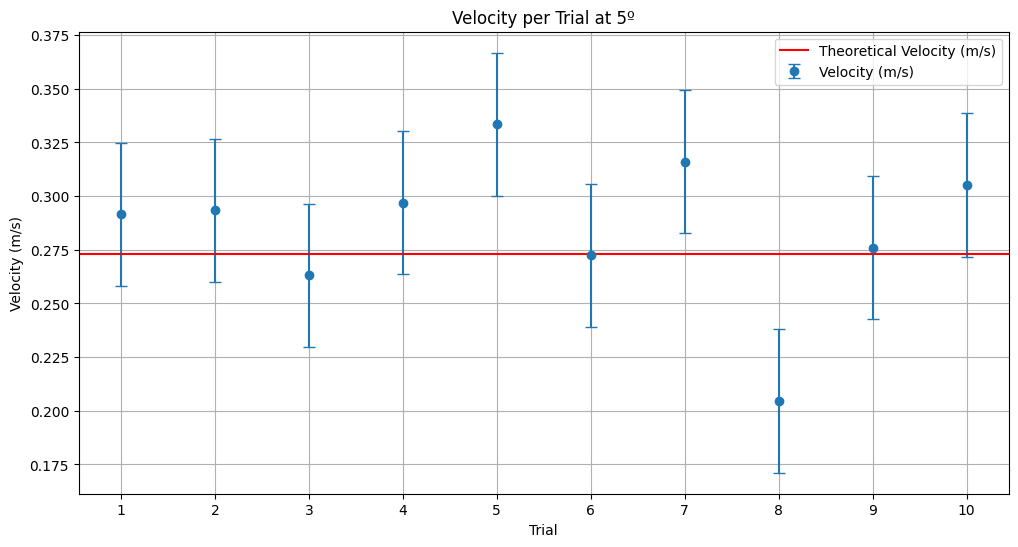

In [15]:
run_deg_computation(5, wf_table=WFS_FIVE_DEG, verbose=[])

## 10

In [16]:
WFS_TEN_DEG = {
    '10-t1': WaveFilter(x_min=12, x_max=23),
    '10-t2': WaveFilter(x_min=5, x_max=20),
    '10-t3': WaveFilter(x_min=20, x_max=33),
    '10-t4': WaveFilter(x_min=7.4, x_max=17),
    '10-t5': WaveFilter(x_min=10, x_max=23),
    '10-t6': WaveFilter(x_min=5, x_max=15),
    '10-t7': WaveFilter(x_min=10, x_max=19),
    '10-t8': WaveFilter(x_min=7.5, x_max=17.5),
    '10-t9': WaveFilter(x_min=10, x_max=20),
    '10-t10': WaveFilter(x_min=12, x_max=30, y_max=0.6),
}

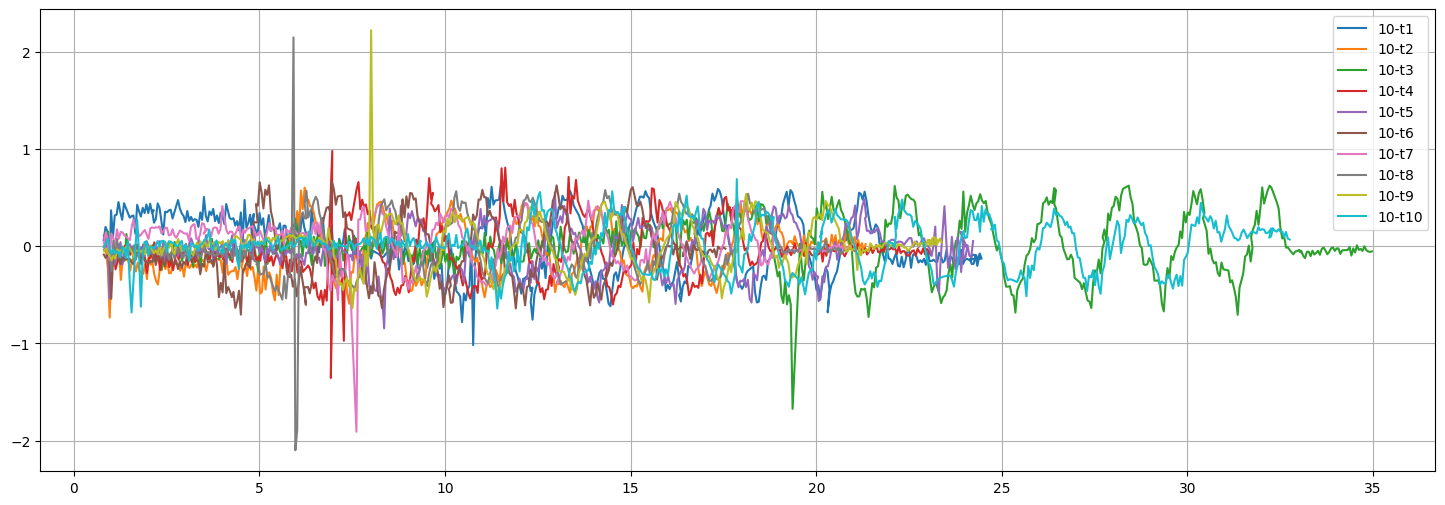

10-t1
trial avg v: 0.6064309612300001
~~~~~~
10-t2
trial avg v: 0.5051964047500002
~~~~~~
10-t3
trial avg v: 0.64681845405
~~~~~~
10-t4
trial avg v: 0.58865852093
~~~~~~
10-t5
trial avg v: 0.5043583734699999
~~~~~~
10-t6
trial avg v: 0.5849383018200001
~~~~~~
10-t7
trial avg v: 0.37780254815200004
~~~~~~
10-t8
trial avg v: 0.47606724127
~~~~~~
10-t9
trial avg v: 0.46440510257000006
~~~~~~
10-t10
trial avg v: 0.49787881708000004
~~~~~~
10deg avg v: 0.5252554725322001
10deg trial stdev: 0.07642130320762798
10deg trial stdev as %: 14.549358779492408%


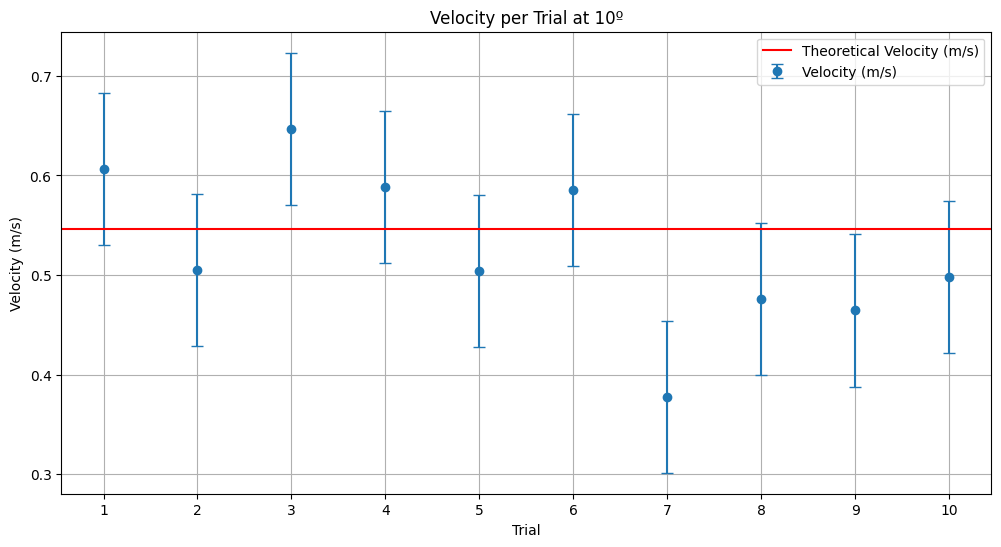

In [17]:
run_deg_computation(10, wf_table=WFS_TEN_DEG, verbose=[])

## 15

In [18]:
WFS_FIFTEEN_DEG = {
    '15-t1': WaveFilter(x_min=5, x_max=15),
    '15-t2': WaveFilter(x_min=7.5, x_max=17.5),
    '15-t3': WaveFilter(x_min=6.5, x_max=17.5),
    '15-t4': WaveFilter(x_min=7.5, x_max=17.5),
    '15-t5': WaveFilter(x_min=7.5, x_max=17.5),
    '15-t6': WaveFilter(x_min=5, x_max=20),
    '15-t7': WaveFilter(x_min=6, x_max=16.5),
    '15-t8': WaveFilter(x_min=4, x_max=15),
    '15-t9': WaveFilter(x_min=5, x_max=15),
    '15-t10': WaveFilter(x_min=6, x_max=15.5),
}

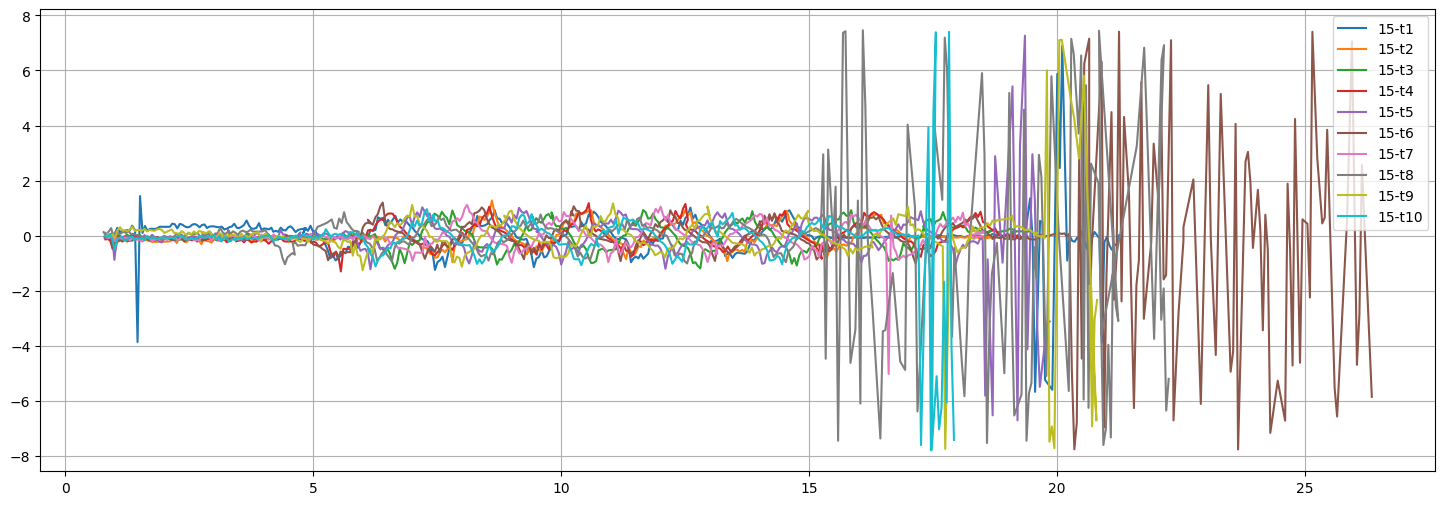

15-t1
trial avg v: 0.9505276440658884
~~~~~~
15-t2
trial avg v: 0.9071233917373401
~~~~~~
15-t3
trial avg v: 1.0009876907131918
~~~~~~
15-t4
trial avg v: 0.8616923323795607
~~~~~~
15-t5
trial avg v: 0.9027975331110308
~~~~~~
15-t6
trial avg v: 0.9647810817133664
~~~~~~
15-t7
trial avg v: 0.9263507696245801
~~~~~~
15-t8
trial avg v: 0.832143696289393
~~~~~~
15-t9
trial avg v: 0.8629916611272771
~~~~~~
15-t10
trial avg v: 0.793822927443588
~~~~~~
15deg avg v: 0.9003218728205216
15deg trial stdev: 0.06034499499790437
15deg trial stdev as %: 6.702602349186078%


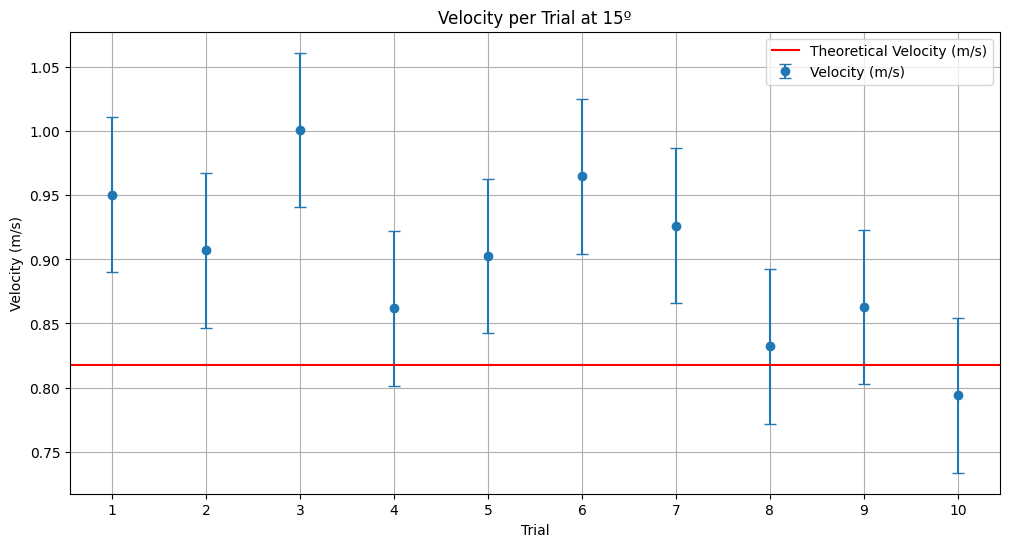

In [19]:
run_deg_computation(15, wf_table=WFS_FIFTEEN_DEG, verbose=[])

## 20

In [20]:
WFS_TWENTY_DEG = {
    '20-t1': WaveFilter(x_min=9, x_max=20, y_max=1.2),
    '20-t2': WaveFilter(x_min=5, x_max=17.5, y_min=-1.5),
    '20-t3': WaveFilter(x_min=14, x_max=25),
    '20-t4': WaveFilter(x_min=10, x_max=20),
    '20-t5': WaveFilter(x_min=5, x_max=15),
    '20-t6': WaveFilter(x_min=13, x_max=23),
    '20-t7': WaveFilter(x_min=10, x_max=24),
    '20-t8': WaveFilter(x_min=7.5, x_max=19, y_max=1.5),
    '20-t9': WaveFilter(x_min=7.5, x_max=17.5),
    '20-t10': WaveFilter(x_min=8, x_max=20, y_min=-1.5),
}

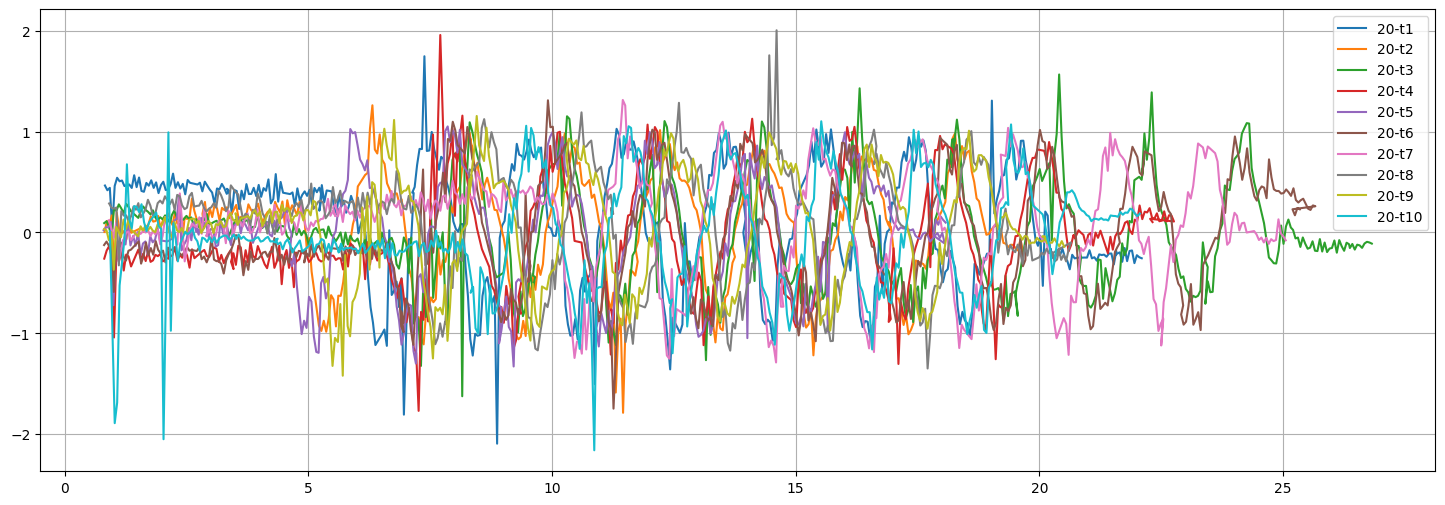

20-t1
trial avg v: 1.0958572804400002
~~~~~~
20-t2
trial avg v: 1.05830473844
~~~~~~
20-t3
trial avg v: 1.0541814276300001
~~~~~~
20-t4
trial avg v: 1.0112718819600002
~~~~~~
20-t5
trial avg v: 1.09279565338
~~~~~~
20-t6
trial avg v: 0.9515654555799999
~~~~~~
20-t7
trial avg v: 1.1649907169599998
~~~~~~
20-t8
trial avg v: 1.0583963669599998
~~~~~~
20-t9
trial avg v: 1.0023896419400002
~~~~~~
20-t10
trial avg v: 0.9722548408669001
~~~~~~
20deg avg v: 1.04620080041569
20deg trial stdev: 0.060555857314357926
20deg trial stdev as %: 5.788167748514157%


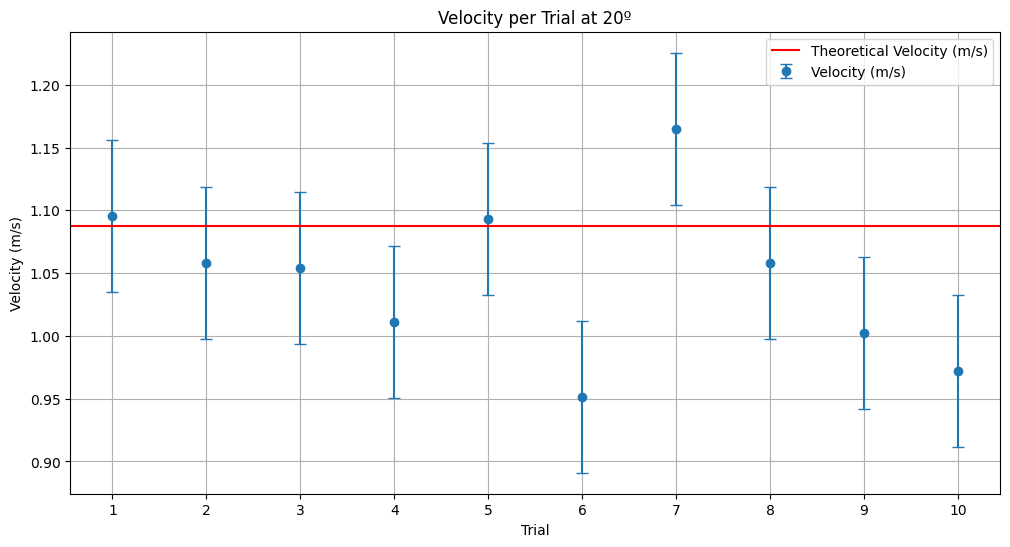

In [21]:
run_deg_computation(20, wf_table=WFS_TWENTY_DEG, verbose=[])

## 25

In [22]:
WFS_TWENTYFIVE_DEG = {
    '25-t1': WaveFilter(x_min=15, x_max=25, y_max=1.5),
    '25-t2': WaveFilter(x_min=10, x_max=25, y_max=1.5, y_min=-1.5),
    '25-t3': WaveFilter(x_min=15, x_max=25),
    '25-t4': WaveFilter(x_min=10, x_max=23),
    '25-t5': WaveFilter(x_min=7.5, x_max=17.5),
    '25-t6': WaveFilter(x_min=7.5, x_max=17.5),
    '25-t7': WaveFilter(x_min=8, x_max=20),
    '25-t8': WaveFilter(x_min=7.5, x_max=17.5),
    '25-t9': WaveFilter(x_min=10, x_max=25, y_max=1.5),
    '25-t10': WaveFilter(x_min=8, x_max=20, y_max=2),    
}

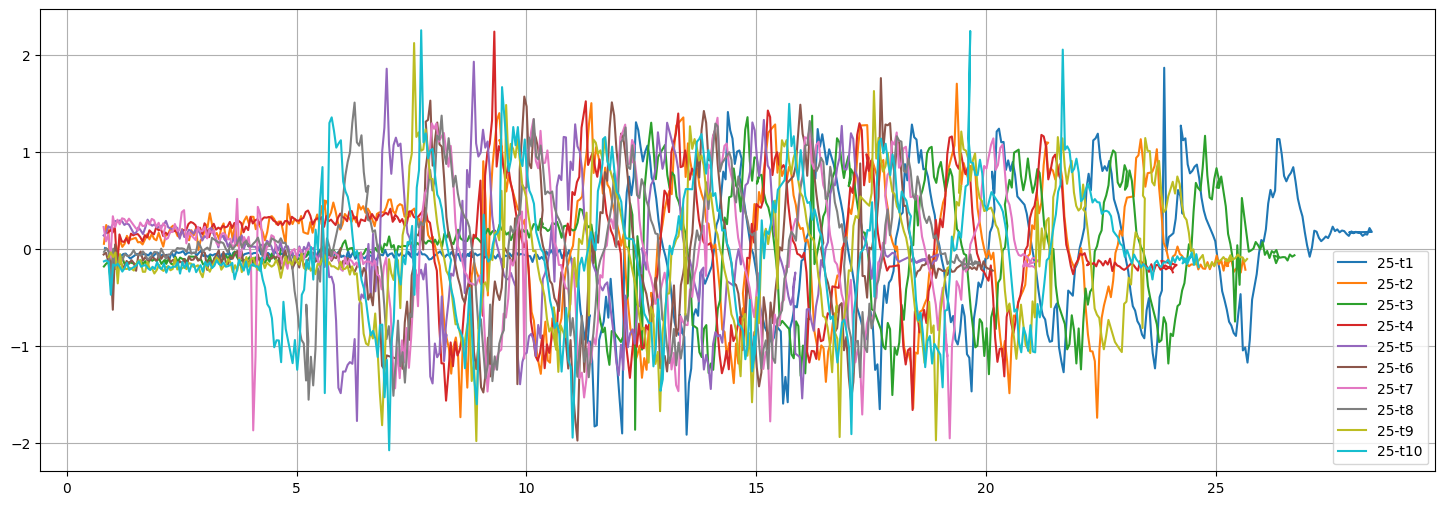

25-t1
trial avg v: 1.222375553131
~~~~~~
25-t2
trial avg v: 1.3008724395999998
~~~~~~
25-t3
trial avg v: 1.19369377771
~~~~~~
25-t4
trial avg v: 1.3637190211
~~~~~~
25-t5
trial avg v: 1.4190763892999998
~~~~~~
25-t6
trial avg v: 1.5355343797999998
~~~~~~
25-t7
trial avg v: 1.4445884317000002
~~~~~~
25-t8
trial avg v: 1.24062173048
~~~~~~
25-t9
trial avg v: 1.4353665237
~~~~~~
25-t10
trial avg v: 1.4990644774
~~~~~~
25deg avg v: 1.3654912723921
25deg trial stdev: 0.11425163490516597
25deg trial stdev as %: 8.367071779596017%


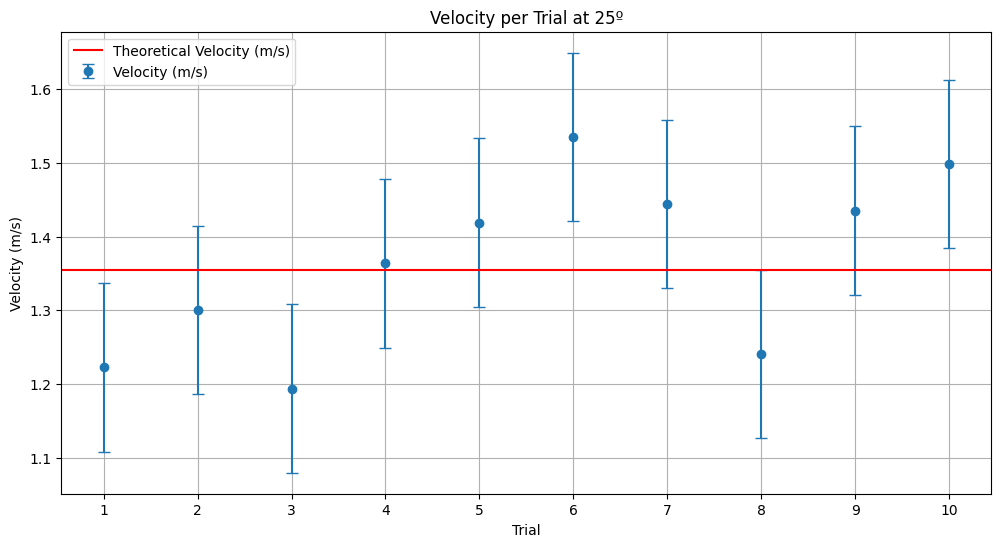

In [23]:
run_deg_computation(25, wf_table=WFS_TWENTYFIVE_DEG, verbose=[])

## 30

In [24]:
WFS_THIRTY_DEG = {
    '30-t1': WaveFilter(x_min=8, x_max=19),
    '30-t2': WaveFilter(x_min=8, x_max=18),
    '30-t4': WaveFilter(x_min=10, x_max=20),
    '30-t5': WaveFilter(x_min=13, x_max=23),
    '30-t6': WaveFilter(x_min=8, x_max=21),
    '30-t7': WaveFilter(x_min=7, x_max=20, y_min=-2),
    '30-t8': WaveFilter(x_min=13, x_max=25),
    '30-t9': WaveFilter(x_min=13, x_max=25, y_min=-2),
    '30-t10': WaveFilter(x_min=10, y_min=-2),
}

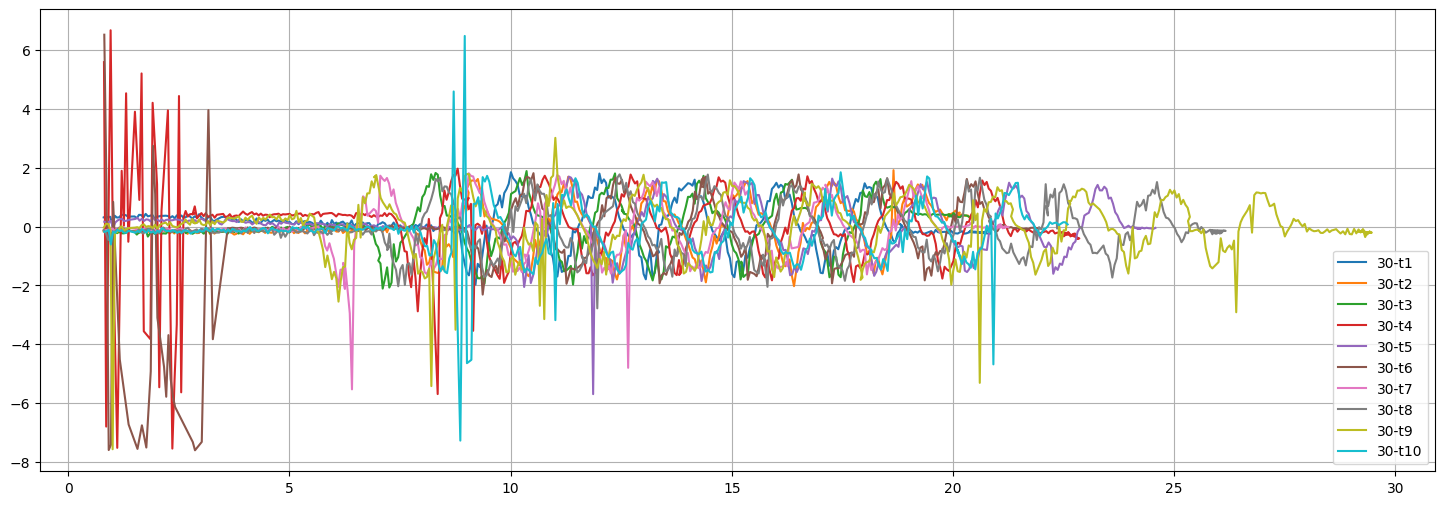

30-t1
trial avg v: 1.698141790766833
~~~~~~
30-t2
trial avg v: 1.6958133380586602
~~~~~~
30-t3
trial avg v: 1.8493795031094749
~~~~~~
30-t4
trial avg v: 1.6341366578406398
~~~~~~
30-t5
trial avg v: 1.4798345056525566
~~~~~~
30-t6
trial avg v: 1.854811172070645
~~~~~~
30-t7
trial avg v: 1.626522219993839
~~~~~~
30-t8
trial avg v: 1.639175322049817
~~~~~~
30-t9
trial avg v: 1.6284262234266322
~~~~~~
30-t10
trial avg v: 1.609356078338271
~~~~~~
30deg avg v: 1.6715596811307372
30deg trial stdev: 0.10651843738257548
30deg trial stdev as %: 6.372398101306224%


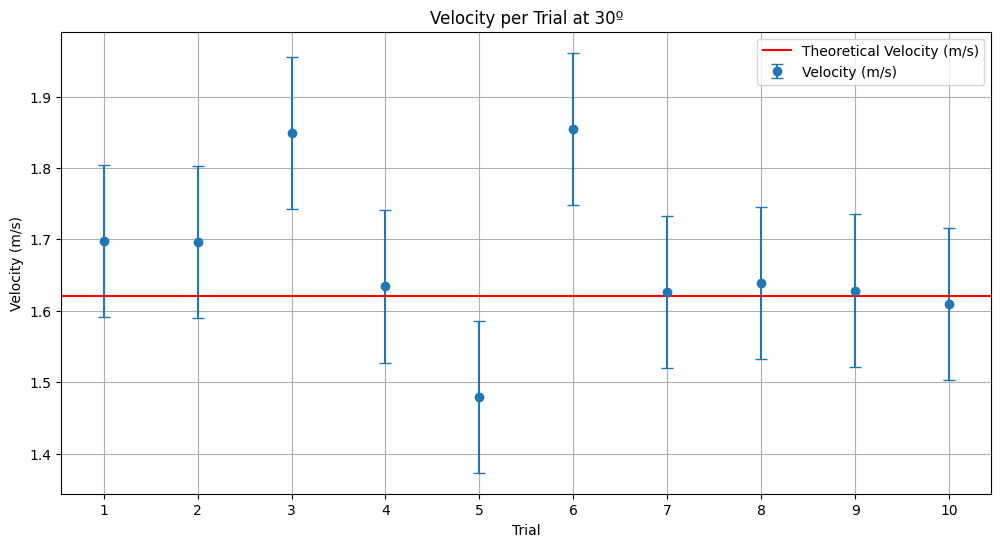

In [25]:
run_deg_computation(30, wf_table=WFS_THIRTY_DEG, verbose=[])

## 35

In [26]:
WFS_THIRTYFIVE_DEG = {
    '35-t1': WaveFilter(x_min=10, x_max=25),
    '35-t2': WaveFilter(x_min=8, x_max=25),
    '35-t3': WaveFilter(x_min=6, x_max=20),
    '35-t4': WaveFilter(y_max=2),
    '35-t10': WaveFilter(y_max=2),
}

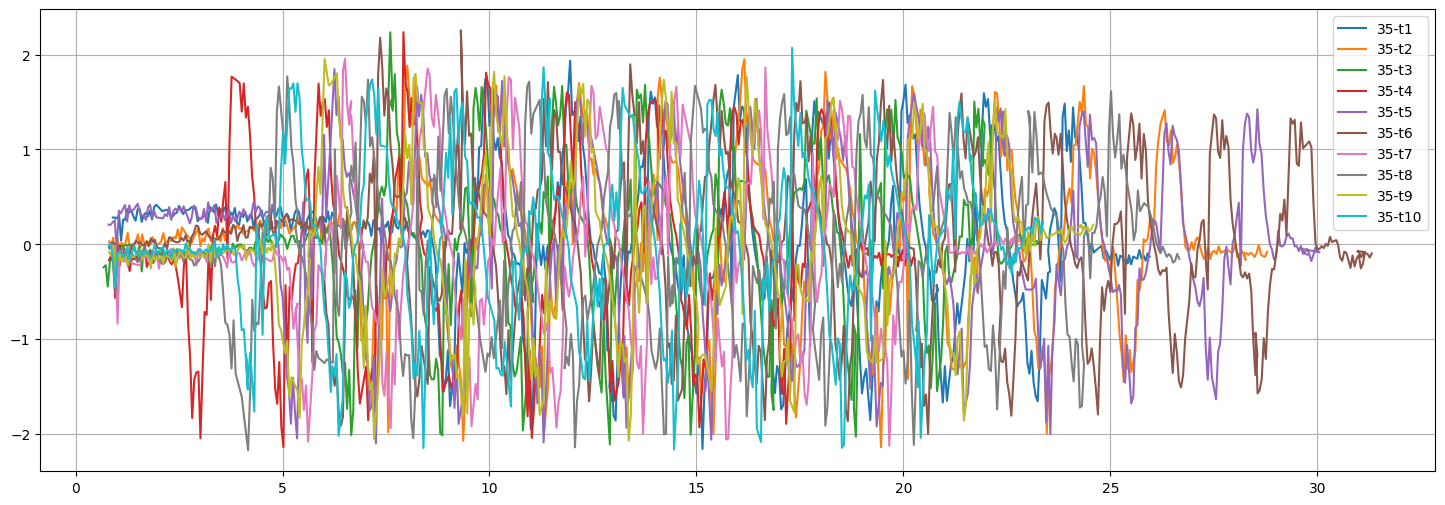

35-t1
trial avg v: 1.8160832253000003
~~~~~~
35-t2
trial avg v: 1.9302840789999998
~~~~~~
35-t3
trial avg v: 1.9040528120000002
~~~~~~
35-t4
trial avg v: 1.8439368535
~~~~~~
35-t5
trial avg v: 1.8692938447
~~~~~~
35-t6
trial avg v: 1.9219013449999998
~~~~~~
35-t7
trial avg v: 1.9297311966
~~~~~~
35-t8
trial avg v: 1.90032048
~~~~~~
35-t9
trial avg v: 1.8679829337
~~~~~~
35-t10
trial avg v: 1.9170307874999999
~~~~~~
35deg avg v: 1.89006175573
35deg trial stdev: 0.03708461825064185
35deg trial stdev as %: 1.962085002683874%


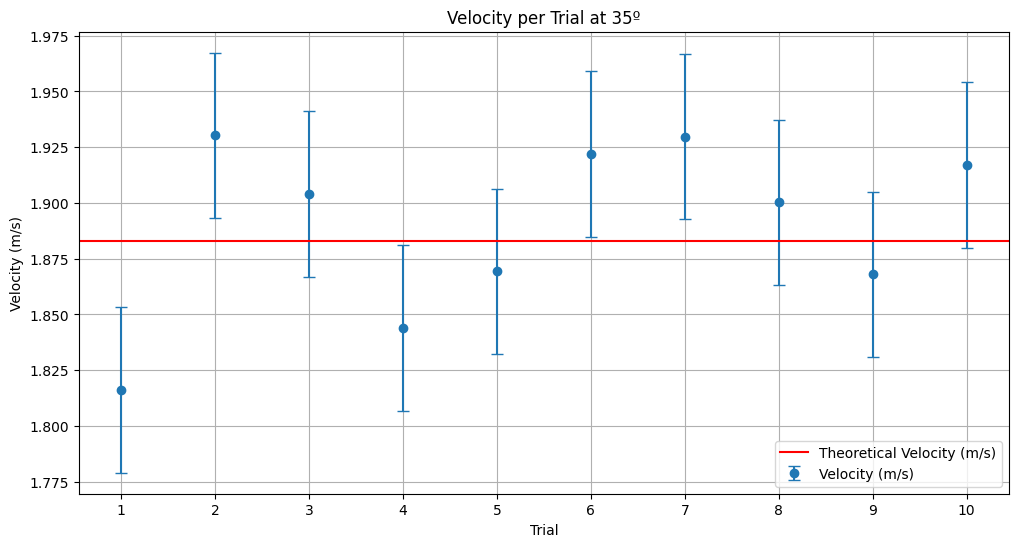

In [27]:
run_deg_computation(35, wf_table=WFS_THIRTYFIVE_DEG, verbose=[])

## 40

In [28]:
WFS_FORTY_DEG = {
    '40-t7': WaveFilter(y_min=-2.1),
    '40-t10': WaveFilter(x_min=7.5, x_max=17.5)
}

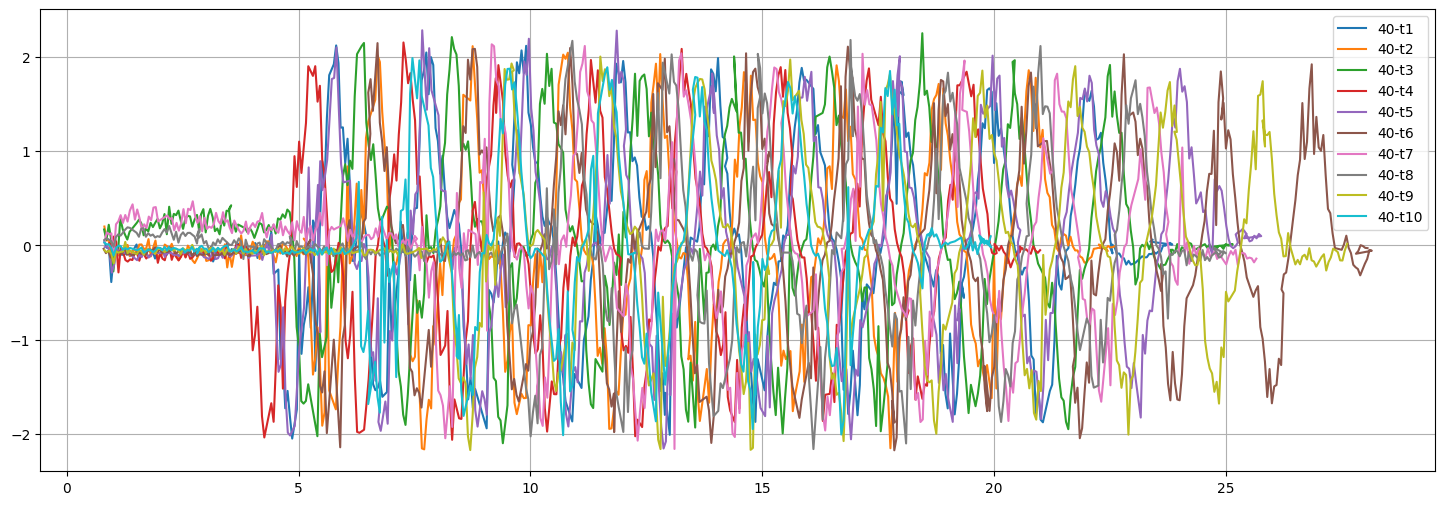

40-t1
trial avg v: 1.9947477416000001
~~~~~~
40-t2
trial avg v: 2.0120387347
~~~~~~
40-t3
trial avg v: 2.0655249430000002
~~~~~~
40-t4
trial avg v: 2.0076368659
~~~~~~
40-t5
trial avg v: 2.0953924445
~~~~~~
40-t6
trial avg v: 2.087795891
~~~~~~
40-t7
trial avg v: 2.0278850069
~~~~~~
40-t8
trial avg v: 2.0632605391999994
~~~~~~
40-t9
trial avg v: 2.0214536931
~~~~~~
40-t10
trial avg v: 1.88626845
~~~~~~
40deg avg v: 2.02620043099
40deg trial stdev: 0.057133321427759065
40deg trial stdev as %: 2.8197270395329928%


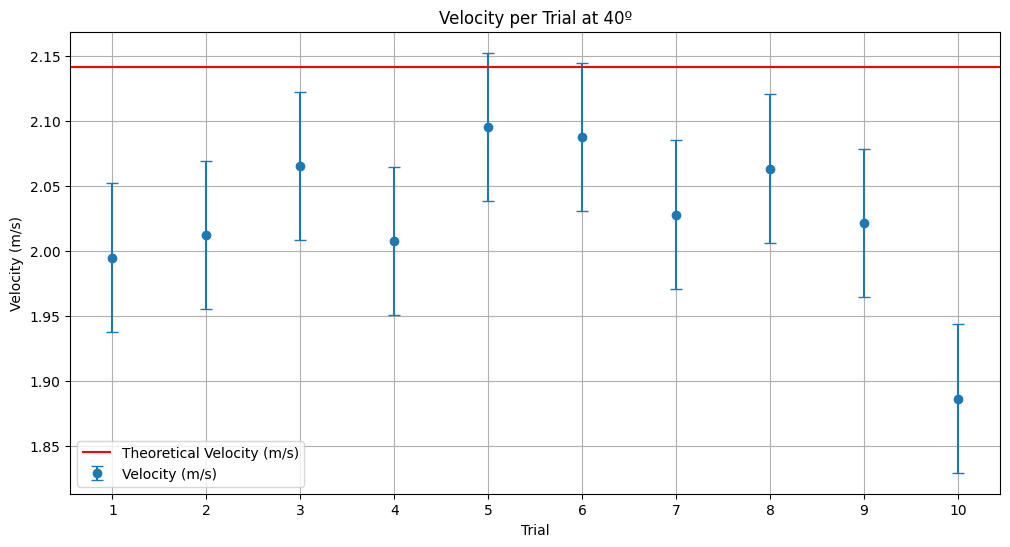

In [29]:
run_deg_computation(40, wf_table=WFS_FORTY_DEG, verbose=[])

## 45

In [30]:
WFS_FORTYFIVE_DEG = {
    '45-t1': WaveFilter(x_min=7.5),
    '45-t2': WaveFilter(x_min=13, x_max=25),
    '45-t3': WaveFilter(x_min=7, x_max=17),
    '45-t4': WaveFilter(y_min=-4),
    '45-t5': WaveFilter(x_min=4),
    '45-t6': WaveFilter(x_min=10, x_max=22),
    '45-t7': WaveFilter(x_min=10, y_min=-4),
    '45-t8': WaveFilter(x_min=15),
    '45-t9': WaveFilter(x_min=7.5),
}

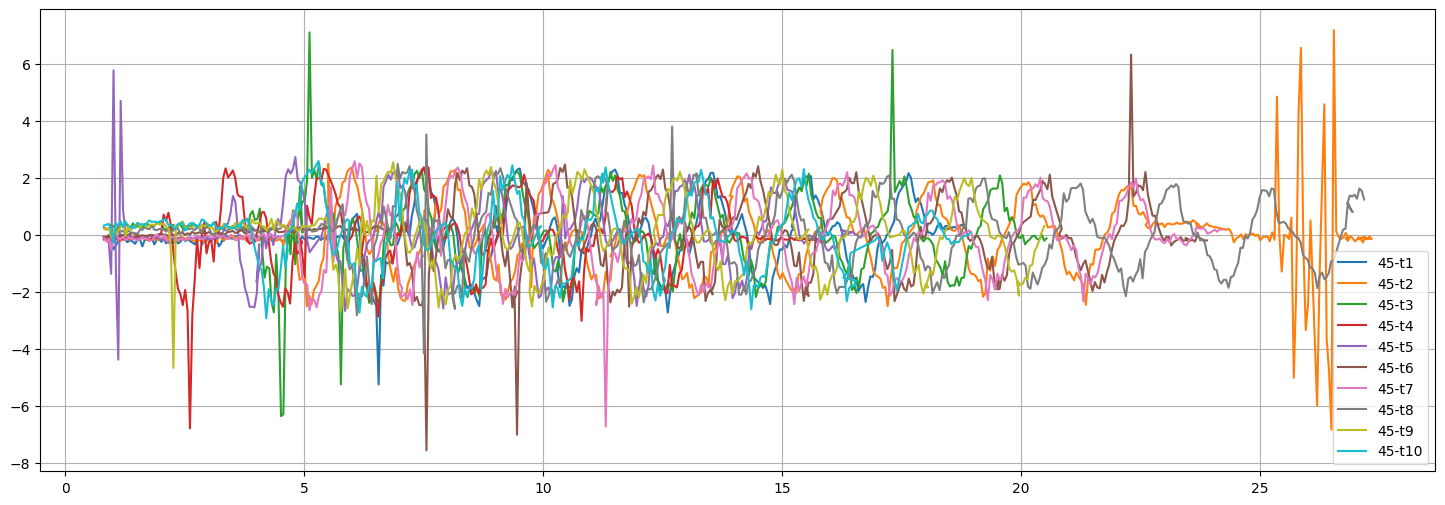

45-t1
trial avg v: 2.232767401019748
~~~~~~
45-t2
trial avg v: 2.091393215875687
~~~~~~
45-t3
trial avg v: 2.015588191941064
~~~~~~
45-t4
trial avg v: 2.375170964665375
~~~~~~
45-t5
trial avg v: 2.3563442463395665
~~~~~~
45-t6
trial avg v: 2.33419146690518
~~~~~~
45-t7
trial avg v: 2.2543410420469137
~~~~~~
45-t8
trial avg v: 1.9769676508707552
~~~~~~
45-t9
trial avg v: 2.3297782678737455
~~~~~~
45-t10
trial avg v: 2.5311806051731702
~~~~~~
45deg avg v: 2.2497723052711205
45deg trial stdev: 0.16566808293646776
45deg trial stdev as %: 7.363771104671993%


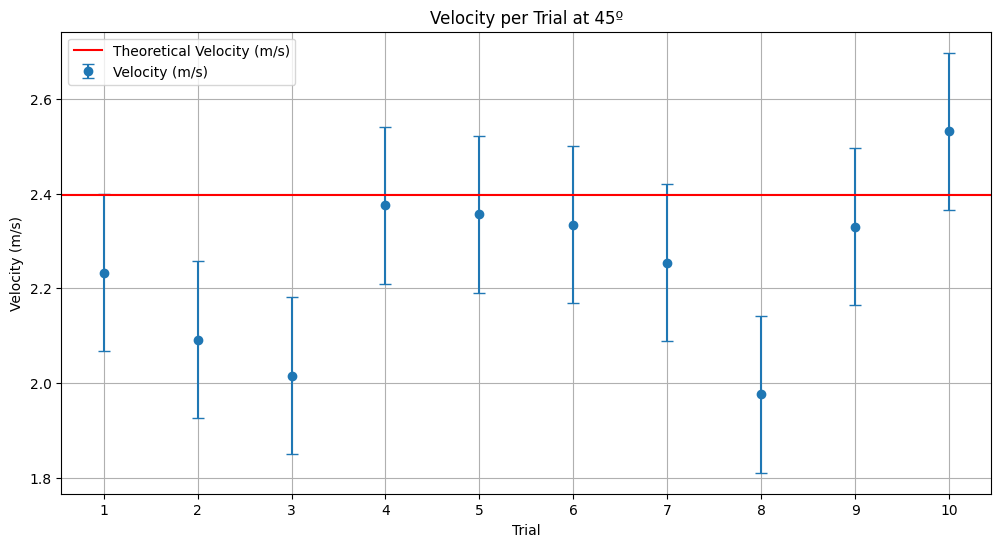

In [31]:
run_deg_computation(45, wf_table=WFS_FORTYFIVE_DEG, verbose=[])

## 60

Unfortunately, the $60^o$ angle proved too difficult to collect data for as the large angle caused some problems in our setup.

## Objective
- 4 angles, 10 samples for each = 40 total
- For each sample, find 5 highest crests + 5 lowest troughs
- absolute value all points
- avg all points

## Graphing
- one overall velocity vs degree line graph
- graph for each item of trials, with line for expected value

In [32]:
results_df_setup = {
    'Angle': [5, 10, 15, 20, 25, 30, 35, 40, 45],
    'Avg. Velocity (m/s)': RESULTS,
    'Theoretical Velocity (m/s)': EXPECTED_VALS.values(),
    'Standard Deviation': STDEVS,
    '% Standard Deviation': PERCENT_STDEVS
}

master_results_df = pd.DataFrame(data=results_df_setup)

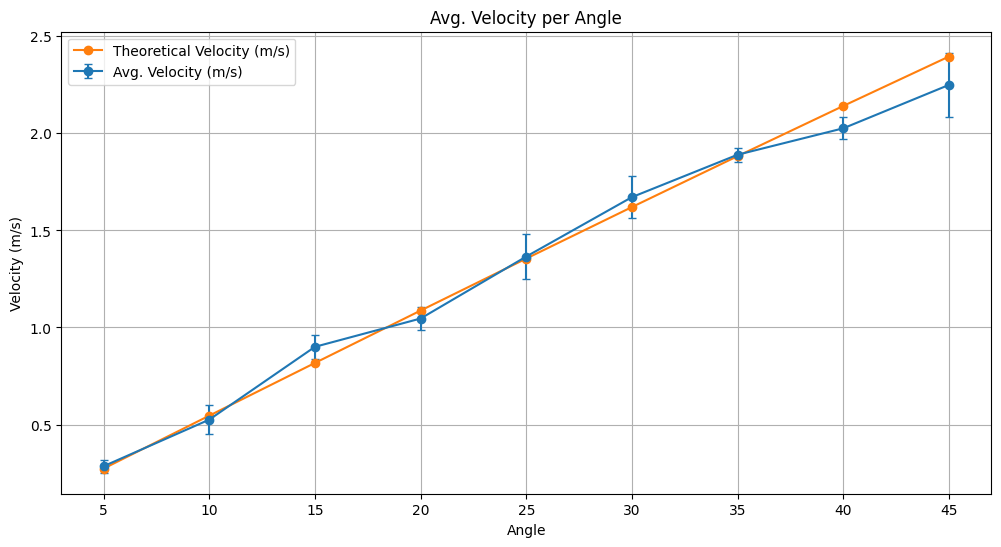

In [33]:
final_results_fig = plt.figure(figsize=[12,6])

plt.errorbar(master_results_df['Angle'], master_results_df['Avg. Velocity (m/s)'], yerr=master_results_df['Standard Deviation'], label='both limits (default)', capsize=3, marker='o')
plt.plot(master_results_df['Angle'], master_results_df['Theoretical Velocity (m/s)'], marker='o')

plt.legend(['Theoretical Velocity (m/s)', 'Avg. Velocity (m/s)'])
plt.xlabel('Angle')
plt.ylabel('Velocity (m/s)')
plt.grid(visible=True)
plt.title('Avg. Velocity per Angle')
plt.show()

In [34]:
final_results_fig.savefig('assets/final_results.png') if SAVE_FIGS else None

In [35]:
# styled table

master_results_df['Avg. Velocity (m/s)'] = master_results_df['Avg. Velocity (m/s)'].map(lambda x: '{0:.2f}'.format(x))
master_results_df['Theoretical Velocity (m/s)'] = master_results_df['Theoretical Velocity (m/s)'].map(lambda x: '{0:.2f}'.format(x))
master_results_df['% Standard Deviation'] = master_results_df['% Standard Deviation'].map(lambda x: '{0:.2f}'.format(x))

master_results_df.style \
    .hide("Standard Deviation", axis='columns') \
    .hide(axis='index')

## Reference links
- [pandas.DataFrame.plot — pandas 2.0.1 documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html)
- [matplotlib.pyplot.errorbar — Matplotlib 3.7.1 documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html#examples-using-matplotlib-pyplot-errorbar)
- [Errorbar limit selection — Matplotlib 3.7.1 documentation](https://matplotlib.org/stable/gallery/lines_bars_and_markers/errorbar_limits_simple.html#sphx-glr-gallery-lines-bars-and-markers-errorbar-limits-simple-py)
- [matplotlib.markers — Matplotlib 3.7.1 documentation](https://matplotlib.org/stable/api/markers_api.html#module-matplotlib.markers)